# Optimizing Source Code

**Advanced Astroinformatics Student Project**

*N. Hernitschek, 2022*



---
## Contents
* [Recap, Questions](#first-bullet)
* [Machine Learning - best practice](#second-bullet)
* [Optimizing Source Code](#third-bullet)
* [Storing and reusing data structures - serializing with `pickle`](#fourth-bullet)
* [Storing and reusing function calls - memoization](#fifth-bullet)
* [Parallelization](#sixth-bullet)
* [Summary](#seventh-bullet)


## 1. Recap, Questions <a class="anchor" id="first-bullet"></a>

Time for questions!

Your **tasks until this week** were:

Use a multiclass supervised machine learning algorithm on the three TESS feature data sets, including making diagnostic plots and the classification scores.

Try to interpret your results.
How do your results differ from the a) _TESS_lightcurves_outliercleaned, b) _TESS_lightcurves_median_after_detrended, c) _TESS_lightcurves_raw?


To which extent could a machine-learning pipeline be helpful?


## 2. Machine Learning - best practice <a class="anchor" id="second-bullet"></a>


* whatever you code - document your code well!

* the training set must have the same data quality as the target set: this can be achieved by either cross-matching your sample with a catalog with existing very accurate classification, generating mock data from theoretical models

* always use verification: 10-fold verification

* make diagnostic plots: triangle plots (for features, clustering), confusion matrix, efficiency-completeness plots

* improve your classification gradually

* think about building a classification pipeline (especially if some features only make sense for a small subset of the data, e.g. periods of light curves)

* after training your model, pickle it

* run the classification in parallel, either using `multiprocessing` or start your code multiple times (multiple jobs); for this, the pickled model should be used for all processes



### 2.1 Imbalanced Data Sets

Our TESS data sets are **imbalanced*:

In [13]:
import pandas as pd

star_types = pd.read_csv('test_featuretable.csv',names = ['type'],usecols = [1],skiprows=1) 

#print(star_types)

print('type occurrances')
    
print(star_types['type'].value_counts())


type occurrances
EW         1092
SR          992
ROT         790
EA          447
RRAB        443
L           236
RRC         203
EC          124
EB          121
DCEP         77
DSCT         71
RRAB_BL      55
ED           54
HADS         31
RRD          23
CEP          22
ACV          21
RS           18
DCEP-FU      10
E             8
RR            6
DCEPS         6
Name: type, dtype: int64


You might have noticed that when using 10-fold verification to measure the classifier's performance, you sometimes run into problems as bootstrap samples miss certain types.

In the following, we see how we can overcome this problem.


The technique used is called **stratified k-fold cross-validation**. This will preserve the distribution of different classes (types) in the bootstrap data sets.

**Example:**

First, we will use the KFold class to randomly split the dataset into 5-folds and check the composition of each train and test set. The complete example is listed below.

We can see that in this case, there are some splits that have the expected 8/2 split for train and test sets, and others that are much worse, such as 6/4 (optimistic) and 10/0 (pessimistic).

Evaluating a model on these splits of the data would not give a reliable estimate of performance:
This would not give the classifier enough examples to learn from, the test set often misses out a certain class, and so both the performance would be poor and the estimate of the performance would be unreliable.




In [18]:
# example of k-fold cross-validation with an imbalanced dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold

# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.99, 0.01], flip_y=0, random_state=1)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X):
    # select rows
    train_X, test_X = X[train_ix], X[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    print('Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

Train: 0=791, 1=9, Test: 0=199, 1=1
Train: 0=793, 1=7, Test: 0=197, 1=3
Train: 0=794, 1=6, Test: 0=196, 1=4
Train: 0=790, 1=10, Test: 0=200, 1=0
Train: 0=792, 1=8, Test: 0=198, 1=2


We can split a dataset randomly, although in such a way that maintains the same class distribution in each subset. This is called **stratification or stratified sampling** and the target variable `y`, the class, is used to control the sampling process.

For example, we can use a version of k-fold cross-validation that preserves the imbalanced class distribution in each fold. It is called stratified k-fold cross-validation and will enforce the class distribution in each split of the data to match the distribution in the complete training dataset.

Below is the same dataset and the same example as above but now with the stratified version of cross-validation.

In [16]:
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.99, 0.01], flip_y=0, random_state=1)

#here is the difference
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X, y):
    # select rows
    train_X, test_X = X[train_ix], X[test_ix]
    train_y, test_y = y[train_ix], y[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y[train_y==0]), len(train_y[train_y==1])
    test_0, test_1 = len(test_y[test_y==0]), len(test_y[test_y==1])
    print('Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

>Train: 0=792, 1=8, Test: 0=198, 1=2
>Train: 0=792, 1=8, Test: 0=198, 1=2
>Train: 0=792, 1=8, Test: 0=198, 1=2
>Train: 0=792, 1=8, Test: 0=198, 1=2
>Train: 0=792, 1=8, Test: 0=198, 1=2


Running the example generates the dataset as before and summarizes the class distribution for the train and test sets for each split.

In this case, we can see that each split matches what we expected in the ideal case.

Each of the examples in the minority class is given one opportunity to be used in a test set, and each train and test set for each split of the data has the same class distribution.

**Todo:** Apply this to your TESS classifier. You only need to exchange `KFold` for `StratifiedKFold`.

## 3. Optimizing Source Code <a class="anchor" id="third-bullet"></a>


Python has the benefits of being a very portable, high-level programming language with many libraries available for especially data science, machine learning, physics and astronomy.

A drawback of Python is that the execution time of Python can be a bit slow in comparison to such as C/C++.

We address this in three ways:
* monitoring code execution time
* avoiding slow program/ data structures
* using C++ inline code


### 3.1 Monitoring code execution time

It is important to monitor the execution time of your code.
Slow execution time often is a result of using less than optimal data structures, as well as common mistakes like reading in the same file over and over again. We will address reasons for slow code execution time in detail in 2.2, but first let's take a look at how to identify slow parts in your code.


There are many python modules like `time`, `timeit`, and `datetime` in Python which can store the time at which the particular section of the program is being executed. In this way, we can calculate the time it took to execute that section. 

 

The following methods can be used to compute time differences:

* `time` module provides various time-related funtions. The module is included in Python’s standard utility modules. `time.time()` method of Time module is used to get the time in seconds since epoch. The handling of leap seconds is platform-dependent.
* `datetime` library defines a function that can be primarily used to get the current time and date. The `now()` function returns the current local date and time, which is defined under `datetime` module.
* `timeit` runs your code millions of times (default value is 1000000) so that you get the statistically most relevant measurement of code execution time.


**Example 1: Computing the time using `time` module and `time.time()` function**

In [6]:
# program to compute the time
# of execution of any python code
import time
 
# we initialize the variable start
# to store the starting time of
# execution of program
start = time.time()
 
# we can take any program but for
# example we have taken the below
# program
a = 0
for i in range(10000):
    a += (i**100)
 
# now we have initialized the variable
# end to store the ending time after
# execution of program
end = time.time()
 
# difference of start and end variables
# gives the time of execution of the
# program in between
print("The time of execution of above program in seconds is :", end-start)

The time of execution of above program in seconds is : 0.06806516647338867


We have computed the time of the above program which came out of the order 10^-2. We can make a table or a plot that gives us the execution time depending on the number of iterations. This will answer us the (quite common) question whether the algorithm **scales well**.

In [10]:
# program to compute the time
# of execution of any python code
# for different number of computations
import time
 
# we initialize a for loop and in each
# iterations store the time of start
# and end of the iterations

print('Time for execution of program')
print('order t (s)')
for j in range(100, 1100, 100):
    start = time.time()
 
    # program to iterate the range of
    # below loop increasing the value
    # in each iterations
    a = 0
    for i in range(j):
        a += (i**100)
 
    # the end variable to store the
    # ending time after execution of
    # program after each iterations
    end = time.time()
 
    # difference of start and end variables
    # gives the time of execution of the program
    # in between in each iterations
    print(   j, round(end-start, 10))

Time for execution of program
order t (s)
100 0.0003886223
200 0.0024273396
300 0.0012047291
400 0.0017044544
500 0.0037145615
600 0.005767107
700 0.0074198246
800 0.0088808537
900 0.0077271461
1000 0.0040960312


We see a general trend in the increase in time of computation for an increase in the number of execution. However, it may not show any linear trend or fixed increments.



**Example 2: Using `datetime` module and `datetime.now` function.**

This method is useful if we want to write a log file.

In [15]:
# program to compute the time of
# execution of any python code
from datetime import datetime
 
# we initialize the variable start to
# store the starting time of execution
# of program
start = datetime.now()
print('start: ', start)
 
# we can take any program but for
# example we have taken the below
# program
a = 0
for i in range(1000):
    a += (i**100)
 
# now we have initialized the variable
# end to store the ending time after
# execution of program
end = datetime.now()

print('end: ', end)

# difference of start and end variables
# gives the time of execution of the
# program in between
print("The time of execution of above program is: ",
      str(end-start)[5:])

start:  2022-06-27 16:08:13.211298
end:  2022-06-27 16:08:13.218085
The time of execution of above program is:  00.006787


**Example 3: Using timeit**

This module provides a simple way to find the execution time of small sections of Python code. The module function `timeit.timeit(stmt, setup, timer, number)` accepts four arguments:

`stmt`: the statement you want to measure; it defaults to `pass`.
    
`setup`: the code that you run before running the stmt; it defaults to `pass`. We generally use this to import the required modules for our code.
    
`timer`: a `timeit.Timer` object; it usually has a sensible default value so you don’t have to worry about it.
    
`number`: the number of executions you’d like to run the `stmt`.

In [16]:
# program to compute the time of
# execution of any python code using timit
 
# importing the required module
import timeit
 
# code snippet to be executed only once
mysetup = "from math import sqrt"
 
# code snippet whose execution time
# is to be measured
mycode = '''
def example():
    mylist = []
    for x in range(100):
        mylist.append(sqrt(x))
'''
 
# timeit statement
print ("The time of execution of above program is :",
       timeit.timeit(setup = mysetup,
                    stmt = mycode,
                    number = 10000))

The time of execution of above program is : 0.0032699559815227985


**Example 4: using a source-code profiler.**
    
The most 'technical' and advanced method on how to monitor code execution time is using a source-code profiler.    
    
`cProfile` and `profile` provide deterministic profiling of Python programs. A profile is a set of statistics that describes how often and for how long various parts of the program executed. These statistics can be formatted into reports via the pstats module.

The Python standard library provides two different implementations of the same profiling interface:

* `cProfile` is recommended for most users; it’s a C extension with reasonable overhead that makes it suitable for profiling long-running programs. Based on lsprof, contributed by Brett Rosen and Ted Czotter.

* `profile`, a pure Python module whose interface is imitated by `cProfile`, but which adds significant overhead to profiled programs. If you’re trying to extend the profiler in some way, the task might be easier with this module. Originally designed and written by Jim Roskind.

    
**Important note on the usage of `profile` and `cProfile`** 

The profiler modules are designed to provide an execution profile for a given program, not for the purpose of creating (accurate) benchmarkings. For the latter, `timeit` is a better choice giving reasonably accurate results. 
This particularly applies to benchmarking Python code against C code: the profilers introduce overhead for Python code, but not for C-level functions, and so the C code would seem faster than any Python one.
A profiler, however, can be used to generally spot which parts of your code take a relatively long time to execute, how often certain calls are made and whether this makes sense. This is the exact usage of a profiler.
    

More on this can be found in the documentation: https://docs.python.org/3/library/profile.html    

In [17]:
import re
import cProfile

def foo():

    character="b"
    reps="2"
    s = "aaaaaaaaaaaaaaaabbcddd"
    patternString = rf"([^{character}])(?=\1{{0,{reps}}}{character})"
    pattern = re.compile(patternString)
    print (re.findall(pattern, s))

cProfile.run('foo()')

['a', 'a', 'a']
         47 function calls in 0.002 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.001    0.001 <ipython-input-17-b89c0b6999f0>:4(foo)
        1    0.000    0.000    0.001    0.001 <string>:1(<module>)
        3    0.000    0.000    0.001    0.000 iostream.py:195(schedule)
        2    0.000    0.000    0.000    0.000 iostream.py:308(_is_master_process)
        2    0.000    0.000    0.000    0.000 iostream.py:321(_schedule_flush)
        2    0.000    0.000    0.001    0.001 iostream.py:384(write)
        3    0.000    0.000    0.000    0.000 iostream.py:91(_event_pipe)
        1    0.000    0.000    0.000    0.000 re.py:233(findall)
        1    0.000    0.000    0.000    0.000 re.py:250(compile)
        2    0.000    0.000    0.000    0.000 re.py:289(_compile)
        3    0.001    0.000    0.001    0.000 socket.py:438(send)
        3    0.000    0.000    0.000    0.000 t

An example where it becomes more clear what you can spot by using a profiler:

In [72]:
import pandas as pd
import cProfile

def get_star_type(lc_id):

    table = pd.read_csv('test_featuretable.csv', names = ['lc','type'],usecols = [0,1], skiprows=1) 
    
    star_type = table.loc[table['lc'] == lc_id, 'type'].iloc[0]
    
    return star_type
    
def main():
    
    stars = ['41259805_sector01_4_2.lc', '306893839_sector01_4_3.lc', '308452159_sector01_4_3.lc', \
             '309148260_sector01_4_3.lc', '327597288_sector01_2_1.lc', '348898673_sector01_4_3.lc', \
             '349409844_sector01_4_3.lc', '350146577_sector01_4_3.lc', '355650641_sector01_2_2.lc', \
             '358467700_sector01_4_3.lc', '364424408_sector01_4_2.lc', '369220372_sector01_1_1.lc', \
             '382512330_sector01_4_3.lc', '392761412_sector01_3_2.lc', '404807716_sector01_4_2.lc', \
             '410451777_sector01_4_3.lc', '441155956_sector01_1_3.lc', '140687857_sector01_4_2.lc', \
             '142109122_sector01_4_2.lc', '150106606_sector01_4_4.lc', '150270037_sector01_4_3.lc', \
             '167167404_sector01_4_3.lc', '267428681_sector01_3_2.lc', '269792822_sector01_3_3.lc', \
             '271642238_sector01_4_2.lc', '276861305_sector01_4_1.lc', '277316247_sector01_4_1.lc', \
             '278863994_sector01_4_4.lc', '293347406_sector01_4_3.lc', '306470448_sector01_4_3.lc', \
             '306577678_sector01_4_3.lc', '306580505_sector01_4_3.lc', '309701876_sector01_4_1.lc', \
             '349413748_sector01_4_3.lc', '350434368_sector01_4_4.lc', '350518415_sector01_4_4.lc', \
             '364588437_sector01_4_2.lc', '373767115_sector01_4_2.lc']  
       
    for star in stars:
        print(star, get_star_type(star))

cProfile.run('main()')

41259805_sector01_4_2.lc ACV
306893839_sector01_4_3.lc ACV
308452159_sector01_4_3.lc ACV
309148260_sector01_4_3.lc ACV
327597288_sector01_2_1.lc ACV
348898673_sector01_4_3.lc ACV
349409844_sector01_4_3.lc ACV
350146577_sector01_4_3.lc ACV
355650641_sector01_2_2.lc ACV
358467700_sector01_4_3.lc ACV
364424408_sector01_4_2.lc ACV
369220372_sector01_1_1.lc ACV
382512330_sector01_4_3.lc ACV
392761412_sector01_3_2.lc ACV
404807716_sector01_4_2.lc ACV
410451777_sector01_4_3.lc ACV
441155956_sector01_1_3.lc ACV
140687857_sector01_4_2.lc CEP
142109122_sector01_4_2.lc CEP
150106606_sector01_4_4.lc CEP
150270037_sector01_4_3.lc CEP
167167404_sector01_4_3.lc CEP
267428681_sector01_3_2.lc CEP
269792822_sector01_3_3.lc CEP
271642238_sector01_4_2.lc CEP
276861305_sector01_4_1.lc CEP
277316247_sector01_4_1.lc CEP
278863994_sector01_4_4.lc CEP
293347406_sector01_4_3.lc CEP
306470448_sector01_4_3.lc CEP
306577678_sector01_4_3.lc CEP
306580505_sector01_4_3.lc CEP
309701876_sector01_4_1.lc CEP
349413748_s

34808/34770    0.012    0.000    0.020    0.000 {built-in method builtins.isinstance}
     8664    0.001    0.000    0.002    0.000 {built-in method builtins.issubclass}
       38    0.000    0.000    0.000    0.000 {built-in method builtins.iter}
4636/3762    0.002    0.000    0.003    0.000 {built-in method builtins.len}
       38    0.000    0.000    0.000    0.000 {built-in method builtins.locals}
       38    0.000    0.000    0.000    0.000 {built-in method builtins.next}
       38    0.000    0.000    0.000    0.000 {built-in method builtins.ord}
       38    0.000    0.000    0.006    0.000 {built-in method builtins.print}
       76    0.000    0.000    0.000    0.000 {built-in method builtins.sorted}
       38    0.000    0.000    0.000    0.000 {built-in method builtins.sum}
       38    0.010    0.000    0.010    0.000 {built-in method io.open}
      114    0.001    0.000    0.001    0.000 {built-in method numpy.arange}
 1064/988    0.003    0.000    0.004    0.000 {built-in

**Question:**
Do you see what's happening?    

### 3.2. avoiding slow program/ data structures


Certain program structures, as well as data structures, tend to be slow in Python.
It is good to know about this and whenever possible, replace these program and data structures by faster ones.


**Example:** Reducing execution time by using list comprehensions
    
Forming a list of all even numbers up to $10^5$ can be done in the following ways:

In [3]:
%%timeit -n 100
  
even =[ ]
for i in range(10**6):
    if i % 2 == 0:
        even.append(i)

101 ms ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [4]:
%%timeit -n 100
  
even =[i for i in range(10**6) if i % 2 == 0]

68.7 ms ± 4.82 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


This time difference matters a lot when these type of lists are part of a very large program.

In [2]:
import time 
  
  
# Using for loop
start = time.time()
a =[ ]
  
for i in range(10**7):
    if i % 2 == 0:
        a.append(i)
          
print("Execution time = ", time.time()-start)
  
# Using list comprehension
start = time.time()
   
a =[i for i in range(10**7) if i % 2 == 0]
print("Execution time = ", time.time()-start)

Execution time =  1.2491912841796875
Execution time =  0.7064037322998047


Another example:

Loop:	80.9 ms ± 3.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


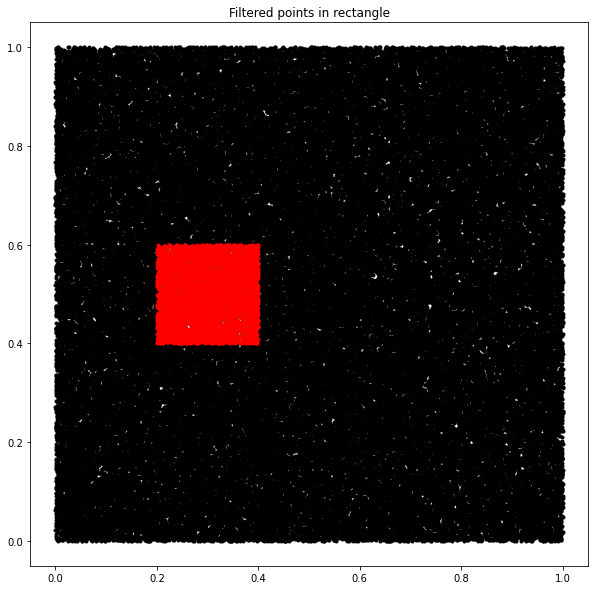

In [3]:
## source: https://gist.github.com/straussmaximilian

import numpy as np


def random_array(size, dim=3):
    """
    Generate a random array of size size and dimension dim
    """
    return np.random.rand(int(size), dim)


def loop(array):
    """
    Takes a numpy array and isolates all points that are within [0.2,0.4]
    for the first column and between [0.4,0.6] for the second column by
    looping through every point.
    """
    filtered_list = []
    for i in range(len(array)):
        # Check if the point is within the rectangle
        if ((array[i][0] >= 0.2)
            and (array[i][1] >= 0.4)
            and (array[i][0] <= 0.4)
            and (array[i][1] <= 0.6)):
            filtered_list.append(array[i])
    return np.array(filtered_list)


# Generate a random array of size 1e5
array = random_array(1e5)
filtered_array = loop(array)

# Measure code execution with inline magic (Jupyter Notebook)
print('Loop:\t', end='')
%timeit loop(array)

# Plot the results
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.title('Filtered points in rectangle')
plt.plot(array[:, 0], array[:, 1], 'k.')
plt.plot(filtered_array[:, 0], filtered_array[:, 1], 'r.')
plt.show()

In [5]:
# source: https://gist.github.com/straussmaximilian

def python_loop(random_list):
    """
    Takes a list of tuples and isolates all points that are within [0.2,0.4]
    for the first dimension and between [0.4,0.6] for the second dimension.
    """
    filtered_list = []
    for i in range(len(random_list)):
        if ((random_list[i][0] >= 0.2)
            and (random_list[i][1] >= 0.4)
            and (random_list[i][0] <= 0.4)
            and (random_list[i][1] <= 0.6)):
            filtered_list.append(random_list[i])
    return filtered_list

# Convert the numpy array to a list of tuples
python_list = list(map(tuple, array))

print('Python loop:\t', end='')
%timeit python_loop(python_list)

Python loop:	29.8 ms ± 3.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 3.3 using compiled inline code

In many cases, it is possible to speed up your code with the methods described above.
Especially for scientific programming, other ways of speeding up our code can be necessary. E.g.: 

When running a MCMC, the likelihood function is repeatedly called with different parameters from the parameter space the MCMC is exploring. The likelihood function can be run in C/C++ which is many times faster. 

An example:


In [7]:
%load_ext Cython

In [8]:


%%cython
def f(n):
      a = 0
      for i in range(n):
          a += i
      return a
    
cpdef g(int n):
      cdef long a = 0
      cdef int i
      for i in range(n):
         a += i
      return a
 

In [9]:
%timeit f(1000000)

41.1 ms ± 5.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%timeit g(1000000)

347 µs ± 43.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Compared to the pure-Python version, the Cython version gives a ${\sim}$95 times improvement. This is possible as C/C++ is not interpreted but compiled to machine code.

More on this:

https://cython.readthedocs.io/en/latest/src/userguide/source_files_and_compilation.html

https://cython.readthedocs.io/en/latest/src/tutorial/cython_tutorial.html


Another way to optimize calculations is the usage of `Numba`.

`Numba` translates Python functions to optimized machine code at runtime using the industry-standard LLVM compiler library. Numba-compiled numerical algorithms in Python can approach the speeds of C or FORTRAN.

You don't need to replace the Python interpreter, run a separate compilation step, or even have a C/C++ compiler installed. Just apply one of the Numba *decorators* to your Python function, and Numba does the rest. 

More on this:
https://numba.pydata.org/

## 4. Storing and reusing data structures - serializing with `pickle` <a class="anchor" id="fourth-bullet"></a>

**Serializing** a Python object structure is the process of converting a Python object into a byte stream to store it in a file/database, maintain program state across sessions, or transport data over the network.

**Question:** Which applications do you see for this?


Imagine we carry out some rather time-expensive calculation at the beginning of our program. This needs to be carried out each time we start our code, e.g. we have to read in a table, calculate some values based on table columns...
In this case it can be useful to simply save that data into a *.txt (*.dat, *.csv) file. This works great for data in a simple table format that we maybe also want to inspect manually.

With more complicated **data structures**, such as e.g. trained classifiers, this becomes infeasible, and **serializing** is the right option.
Also, even for *.txt files, reading in a serialized file can save a lot of time.

The `pickle` module implements binary protocols for serializing and de-serializing a Python object structure. 

In the following, we will use the `pickle` module to serialize a Python object.


More on this:

https://docs.python.org/3/library/pickle.html

In [27]:
# Save a dictionary into a pickle file. For illustration purposes, a simple object was chosen.
import pickle

galaxies = {"Andromeda Galaxy": "NGC 224", "Messier 32": "NGC 221", "Sculptor Galaxy": "NGC 253",
            "Small Magellanic Cloud": "NGC 292"}

pickle.dump(galaxies, open( "galaxies.pickle", "wb" ) )

In [28]:
# Load the dictionary back from the pickle file.
import pickle
 
galaxies = pickle.load( open( "galaxies.pickle", "rb" ) )

print(galaxies)

{'Andromeda Galaxy': 'NGC 224', 'Messier 32': 'NGC 221', 'Sculptor Galaxy': 'NGC 253', 'Small Magellanic Cloud': 'NGC 292'}


*Some comments on using `pickle`:*

* *Be cautious with pickle files from unknown/ not trustworthy sources.*
Pickle files can contain code. This includes potential malicious code that would run once to de-pickle it.
Only use pickle files you created on your own


* *What can be pickled?*
A general rule: you can pickle any object for which you can pickle every attribute. 
A complete list can be found here: https://docs.python.org/3/library/pickle.html#what-can-be-pickled-and-unpickled


* *Don't use pickle to store results.*
Serialized data can cause problems if you save a pickle, then update your code and read the pickle in. Attribute added to your __init__ may not be present in the unpickled object; also, if pickle can't find your class and module (e.g., if you renamed the module) you will get errors.
For this reason, you should be wary of using pickles for long-term storage where the underlying code is not highly stable. It should only be used to speed up code by reading in data structures faster, which however should always be reproducible. I.e.: Your program starts with reading in an initial file, do some calculations on it before the "real" purpose of your program (e.g.: in the beginning, you read in a file containing a list of astronomical objects and you retrieve their coordinates). You can pickle it, and if for any reason the pickle is lost, you can always recreate it. The same is true with a trained classifier: You train a classifier, and before applying it (to a very large data set), you pickle it. You can always re-train your classifier if necessary.

## 5. Storing and reusing function calls - memoization <a class="anchor" id="fifth-bullet"></a>



In computing, **memoization** or memoisation is an optimization technique used primarily to speed up computer programs by **storing the results of expensive function calls** and returning the cached result when the same inputs occur again. Although this is related to caching, memoization refers to a specific case of this optimization, distinguishing it from forms of caching such as buffering.

One example: We might use memoization to cache the results of a function like that:



In [ ]:

def _download_and_preprocess_neighbors(
    corrected_lc: LightCurve,
    radius: float = 6000.0,
    min_targets: int = 30,
    max_targets: int = 50,
    interpolate: bool = False,
    author: tuple = ("Kepler", "K2", "SPOC"),
    flux_column: str = "sap_flux",
):


This is the function definition of a function that downloads and processes sources which are within a given radius around a source provided as input.

When this function is called with input parameters it was called with before, the memoized result from the previous call (with the same parameters) should be reused.

**Example:** computing factorials using memoization in Python

To memoize a function in Python, we can use a utility supplied in Python’s standard library: the `functools.lru_cache` decorator.
We compute the Fibonacci sequence* and check the execution time:


*The Fibonacci sequence is defined as the sequence of the Fibonacci numbers, wich can be defined by the
recurrence relation
$F_{0}=0, \, F_{1}=1,$
$F_{n}=F_{n-1}+F_{n-2}$
for $n > 1$.
This gives
$0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55, 89, 144, ...$



In [47]:
import memoization
from memoization import cached
  
# Function that computes Fibonacci 
# numbers without memoization
def fib_without_cache(n):
    if n < 2:
        return n
    return fib_without_cache(n-1) + fib_without_cache(n-2)
      
# Execution start time
begin = time.time()
fib_without_cache(30)
  
# Execution end time
end = time.time()
  
print("Time taken to execute the function without memoization is", end-begin)
  
# Function that computes Fibonacci
# numbers with memoization
@cached
def fib_with_cache(n):
    if n < 2:
        return n
    return fib_with_cache(n-1) + fib_with_cache(n-2)
      
begin = time.time()
fib_with_cache(30)
end = time.time()
  
print("Time taken to execute the function with memoization is", end-begin)


Time taken to execute thefunction without memoization is 0.2650876045227051
Time taken to execute the function with memoization is 0.0001499652862548828


By default, memoization tries to combine all your function arguments and calculate its hash value using `hash()`. If it turns out that parts of your arguments are unhashable, memoization will fall back to turning them into a string using `str()`. This behavior relies on the assumption that the string exactly represents the internal state of the arguments, which is true for built-in types.

However, this is not true for all objects. If you pass objects which are instances of non-built-in classes, sometimes you will need to override the default key-making procedure, because the `str()` function on these objects may not hold the correct information about their states.


More on this can be found in the documentation:
https://pypi.org/project/memoization/

## 6. Parallelization <a class="anchor" id="sixth-bullet"></a>

When processing large data sets, parallelization is usually possible and thus recommended. In most cases, such code runs on a large number of data independently from each other.
e.g.: classifying objects by their light curves, calculating features for objects, estimating the distances...

`multiprocessing` is a package that supports spawning processes using an API similar to the threading module. It runs on both Unix (including Mac) and Windows.

More on this: https://docs.python.org/3/library/multiprocessing.html



**Example:** a template to process multiple light curves in parallel

In [54]:
from multiprocessing import Pool

# demo code for processing one light curve
def one_lc(param):

    i, filename = param
    
    # here goes the code processing something, i.e.: open the file, carry out computations on light curve data
    
    return filename





pool = Pool(processes=9)

#a list of light curve files
filenames = ['lightcurve_1.lc','lightcurve_2.lc','lightcurve_3.lc']

params = [(i, filename) for i, filename in enumerate(filenames)]

it = pool.imap_unordered(one_lc, params)


for i, res in enumerate(it):

    print('res', res)


pool.terminate()
    
    

res lightcurve_1.lc
res lightcurve_2.lc
res lightcurve_3.lc


**Caution**: Some large **clusters/ supercomputers** prefer to have parallelization implemented in a different way. E.g.: Some clusters have *quotas* on the memory usage, CPU usage, and the runtime of your code within one thread/ process, so it can make sense to rather split up your code in multiple **jobs** instead of using Python's parallelization. When using a cluster/ supercomputer, you will find this in the system's documentation.

**Your tasks until next week:**

Take a look at your classification results so far. You will find types of variable stars that can be classified well with the current approach, whereas others are hard to distinguish. Taking a look at the VSX catalog, and taking a look at the triangle plot (which shows the regions in the parameter space occupied by each type) will often give you a clue why certain types are hard to distinguish. (**Hint**: Reasons could be such as similar periods.)

Based on what you have seen and done so far: Think about ways to improve the classification process.
Our data set is an **imbalanced data set**, so you should modify your code accordingly for the 10-fold verification.

Things you might think about, describe the concept for the project report (and only and if you have time, try to code it up):
Using a (simple) form of classification pipeline, where classification is first done on a smaller set of features, and more features (especially computationally expensive ones) are calculated based on first classification results, will be helpful. Also, unsupervised clustering and a supervised approach such as the Random Forest classifier can be combined.

**Hint:** You can always look up how others tried to solve similar problems. See e.g. my papers on classifying variable sources.

## Summary <a class="anchor" id="fifth-bullet"></a>

At this point, all of you should have seen ways on how to improve the execution time of Python code.

You might not need this in your project now, but it can be helpful later on (i.e.: when you're working on larger data sets, e.g. for your thesis project).